In [30]:
import numpy as np
from scipy.signal import butter, filtfilt, detrend
import os

# ---------- 1) Decode ----------
def decode_iwr6843_data(filename, num_rx=4, num_adc_samples=256, num_chirps=64, header_bytes=0):
    with open(filename, 'rb') as f:
        f.seek(header_bytes)
        raw = np.fromfile(f, dtype=np.int16)
    raw = raw.reshape(-1, 2)
    complex_data = raw[:, 0] + 1j*raw[:, 1]
    samples_per_frame = num_rx * num_chirps * num_adc_samples
    num_frames = len(complex_data) // samples_per_frame
    complex_data = complex_data[:num_frames * samples_per_frame]

    adc = np.empty((num_frames, num_rx, num_chirps, num_adc_samples), dtype=complex)
    for fr in range(num_frames):
        base = fr * samples_per_frame
        for rx in range(num_rx):
            st = base + rx * (num_chirps * num_adc_samples)
            en = st + (num_chirps * num_adc_samples)
            adc[fr, rx] = complex_data[st:en].reshape(num_chirps, num_adc_samples)
    return adc  # (F, RX, C, S)

# ---------- 2) Range FFT ----------
def range_fft(adc):
    return np.fft.fft(adc, axis=-1)  # (F, RX, C, R)

# ---------- 3) Collapse RX & chirps → slow-time per range bin ----------
def slowtime_per_range(rp):
    # average over RX and chirps → (frames, range_bins)
    return rp.mean(axis=(1,2))

# ---------- Filters & Goertzel ----------
def bandpass_keep(x_txb, fs, low, high, order=4):
    """
    x_txb: (T, B) real or complex, filter along T for each bin B
    Returns band-limited signal with only [low, high] Hz kept.
    """
    T, B = x_txb.shape
    ny = fs / 2.0
    b, a = butter(order, [low/ny, high/ny], btype='band')
    y = np.empty_like(x_txb.real)  # work with real magnitudes for physiology
    # detrend + magnitude before bandpass is common for micro-motion
    X = np.abs(x_txb)
    for bcol in range(B):
        y[:, bcol] = filtfilt(b, a, detrend(X[:, bcol], type='constant'))
    return y  # (T, B) real band-limited

def goertzel_power_1d(y, fs, f):
    N = len(y)
    k = int(round(f * N / fs))
    w = 2*np.pi*k/N
    c = 2*np.cos(w)
    s0 = s1 = 0.0
    for n in range(N):
        s2 = s1
        s1 = s0
        s0 = y[n] + c*s1 - s2
    return s0*s0 + s1*s1 - c*s0*s1

def check_specific_bpm(y_txb, fs, candidates_bpm):
    """
    y_txb: (T,B) band-limited real signal
    Returns dict with per-bin powers and overall summary.
    """
    T, B = y_txb.shape
    energy = np.sum(y_txb**2) + 1e-12
    results = {}
    for bpm in candidates_bpm:
        f = bpm/60.0
        p_bins = np.array([goertzel_power_1d(y_txb[:,b], fs, f) for b in range(B)])
        results[bpm] = {
            "per_bin_power": p_bins,
            "total_power_norm": float(p_bins.sum()/energy),
            "best_bin": int(np.argmax(p_bins)),
            "best_bin_power": float(p_bins.max())
        }
    return results

# ---------- 4) Main example ----------
if __name__ == "__main__":
    FILE    = "/home/jupyter-karla/paper_MIMIC/plots/Side/003_Side_3m_0deg_Man2_CondA_CondB_ADC256_Chirp128_SR1000_RE60_FR40_Gain30_FS30_IWR_0.bin"
    fs_time = 25.0  # frames per second — set this correctly!

    # Bands you want to KEEP
    RESP_BAND  = (0.10, 0.60)  # Hz
    HEART_BAND = (0.80, 2.00)  # Hz

    # Candidate BPMs to look for (edit as needed)
    resp_candidates  = [14, 12]      # bpm
    heart_candidates = [80, 60]  # bpm

    # 1) decode → 2) range FFT → 3) slow-time per range
    adc = decode_iwr6843_data(FILE)
    rp  = range_fft(adc)                  # (F, RX, C, R)
    ST  = slowtime_per_range(rp)          # (F, R), complex slow-time per range bin

    # 4) KEEP ONLY band content (this is your “filtered & kept” signal)
    ST_resp_only  = bandpass_keep(ST, fs_time, *RESP_BAND)   # (F, R)
    ST_heart_only = bandpass_keep(ST, fs_time, *HEART_BAND)  # (F, R)

    # 5) From there, test specific frequencies
    resp_report  = check_specific_bpm(ST_resp_only,  fs_time, resp_candidates)
    heart_report = check_specific_bpm(ST_heart_only, fs_time, heart_candidates)

    # ---- Print a compact summary ----
    def pretty(report, label):
        print(f"\n[{label}] candidate frequency check (bpm):")
        for bpm, rec in report.items():
            print(f"  {bpm:5.1f} bpm -> total_power_norm={rec['total_power_norm']:.4f}, "
                  f"best_bin={rec['best_bin']}, best_bin_power={rec['best_bin_power']:.3g}")
    pretty(resp_report,  "Respiration")
    pretty(heart_report, "Heart")

    # Optional: if you want ONE composite trace per band (keeping all bins):
    # Sum across range bins after band-limit (still “kept-only” content)
    resp_composite  = ST_resp_only.sum(axis=1)   # (F,)
    heart_composite = ST_heart_only.sum(axis=1)  # (F,)



[Respiration] candidate frequency check (bpm):
   14.0 bpm -> total_power_norm=38.5651, best_bin=103, best_bin_power=6.03e+09
   12.0 bpm -> total_power_norm=38.5219, best_bin=103, best_bin_power=6.2e+09

[Heart] candidate frequency check (bpm):
   80.0 bpm -> total_power_norm=9.3826, best_bin=96, best_bin_power=1.04e+09
   60.0 bpm -> total_power_norm=5.0033, best_bin=107, best_bin_power=4.07e+08


In [31]:
import numpy as np
from scipy.signal import butter, filtfilt, detrend

# ------------------ I/O & core transforms ------------------
def decode_iwr6843_data(filename, num_rx=4, num_adc_samples=256, num_chirps=64, header_bytes=0):
    with open(filename, 'rb') as f:
        f.seek(header_bytes)
        raw = np.fromfile(f, dtype=np.int16)
    raw = raw.reshape(-1, 2)
    z = raw[:,0] + 1j*raw[:,1]
    spf = num_rx * num_chirps * num_adc_samples
    num_frames = len(z) // spf
    z = z[:num_frames*spf]

    adc = np.empty((num_frames, num_rx, num_chirps, num_adc_samples), dtype=np.complex64)
    for fr in range(num_frames):
        base = fr*spf
        for rx in range(num_rx):
            st = base + rx*(num_chirps*num_adc_samples)
            en = st + (num_chirps*num_adc_samples)
            adc[fr, rx] = z[st:en].reshape(num_chirps, num_adc_samples)
    return adc  # (F,RX,C,S)

def range_fft(adc):  # → range bins
    return np.fft.fft(adc, axis=-1)  # (F,RX,C,R)

# Build complex slow-time per (RX, range-bin) by *coherently* summing chirps
def slowtime_per_rx_range(rp):
    # Sum over chirps keeps complex phase; shape (F, RX, R)
    return rp.sum(axis=2)

# ------------------ filtering (preserve complex) ------------------
def complex_bandpass(x_t, fs, low, high, order=4):
    """Filter real & imag with the same IIR to preserve complex signal."""
    ny = fs/2.0
    b, a = butter(order, [low/ny, high/ny], btype='band')
    xr = filtfilt(b, a, detrend(x_t.real, type='constant'))
    xi = filtfilt(b, a, detrend(x_t.imag, type='constant'))
    return xr + 1j*xi

def band_power(x_t):
    """Total energy in time (L2^2)."""
    return float(np.sum(np.abs(x_t)**2))

# ------------------ selection logic ------------------
def select_best_bin_and_rx(ST, fs, band):
    """
    ST: (F, RX, R) complex slow-time
    band: (lowHz, highHz)
    Returns: dict with indices and the kept complex time series.
    """
    F, RX, R = ST.shape
    best = {"rx": None, "rbin": None, "power": -1.0, "series": None}
    for r in range(R):
        for rx in range(RX):
            y = complex_bandpass(ST[:, rx, r], fs, *band)
            p = band_power(y)
            if p > best["power"]:
                best = {"rx": rx, "rbin": r, "power": p, "series": y}
    return best

# ------------------ main example ------------------
if __name__ == "__main__":
    FILE    = "/home/jupyter-karla/paper_MIMIC/plots/Side/003_Side_3m_0deg_Man2_CondA_CondB_ADC256_Chirp128_SR1000_RE60_FR40_Gain30_FS30_IWR_0.bin"
    fs_time = 25.0  # frames per second — set correctly!
    RESP_BAND  = (0.10, 0.60)  # Hz
    HEART_BAND = (0.80, 2.00)  # Hz

    adc = decode_iwr6843_data(FILE)
    rp  = range_fft(adc)                         # (F,RX,C,R)
    ST  = slowtime_per_rx_range(rp)              # (F,RX,R) complex

    # 1) Pick the single best bin/RX for respiration (by band power)
    best_resp = select_best_bin_and_rx(ST, fs_time, RESP_BAND)
    print(f"[Resp] best rbin={best_resp['rbin']}, rx={best_resp['rx']}, power={best_resp['power']:.3g}")

    # 2) Pick the single best bin/RX for heart (by band power)
    best_heart = select_best_bin_and_rx(ST, fs_time, HEART_BAND)
    print(f"[Heart] best rbin={best_heart['rbin']}, rx={best_heart['rx']}, power={best_heart['power']:.3g}")

    # Your “beams”: complex time series kept ONLY in-band
    resp_beam  = best_resp["series"]   # complex (F,)
    heart_beam = best_heart["series"]  # complex (F,)

    # (Optional) save
    np.save("resp_beam_complex.npy",  resp_beam)
    np.save("heart_beam_complex.npy", heart_beam)
    # or CSV with real/imag columns:
    np.savetxt("resp_beam_complex.csv",  np.c_[resp_beam.real,  resp_beam.imag], delimiter=",", header="real,imag", comments="")
    np.savetxt("heart_beam_complex.csv", np.c_[heart_beam.real, heart_beam.imag], delimiter=",", header="real,imag", comments="")


[Resp] best rbin=116, rx=0, power=5.14e+12
[Heart] best rbin=116, rx=1, power=9.05e+12


Respiration beam peak: 0.256 Hz (15.4 bpm)
Heart beam peak: 1.929 Hz (115.7 bpm)


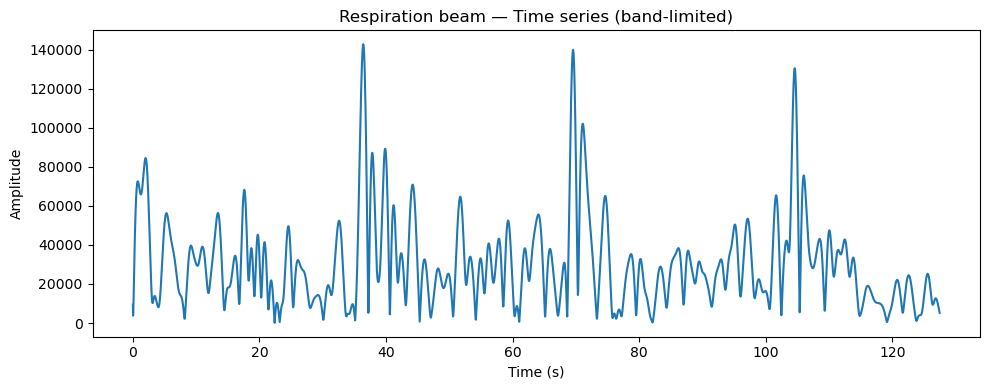

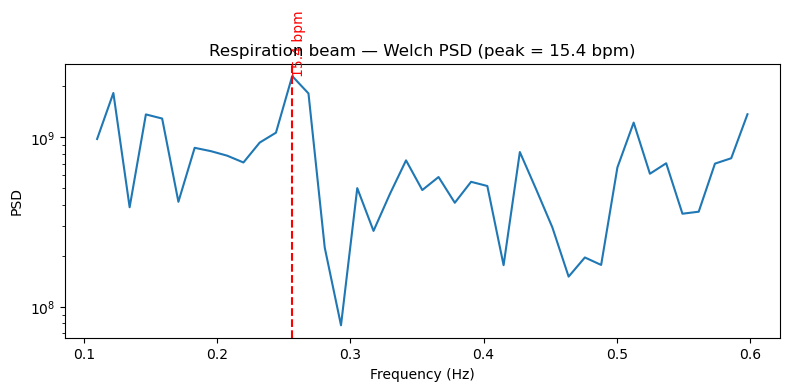

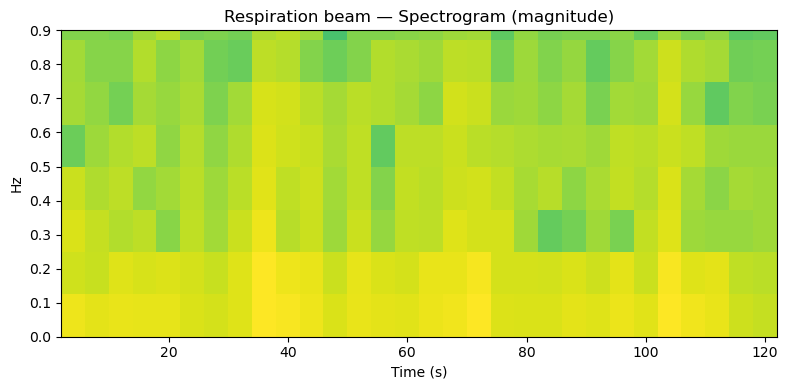

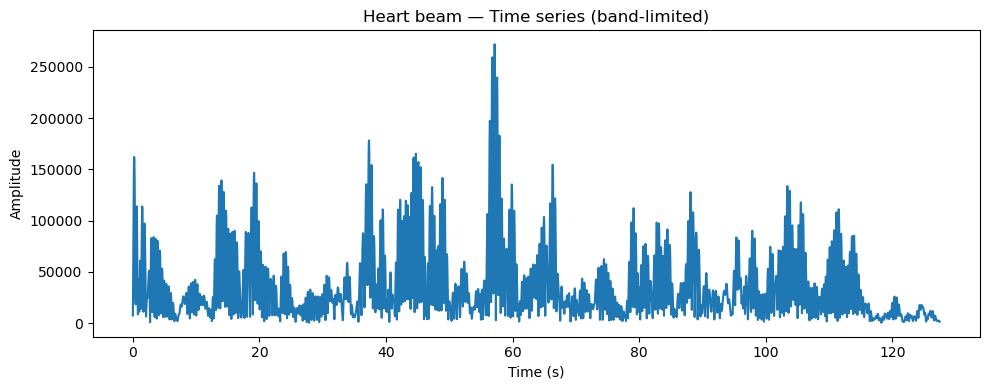

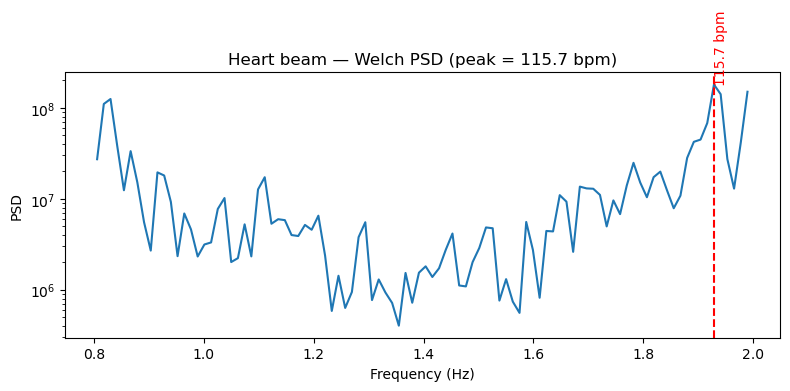

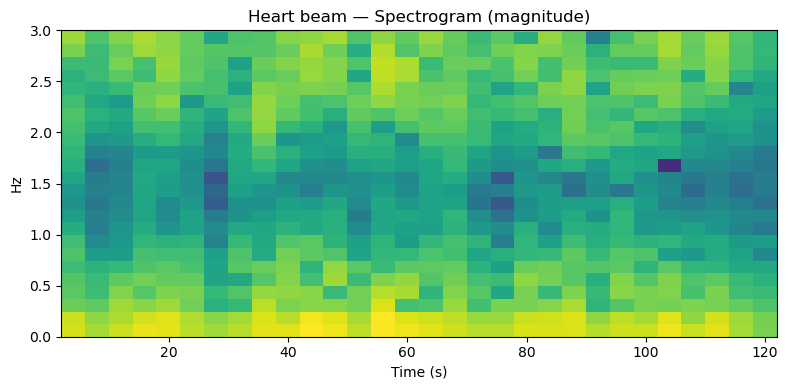

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, welch, detrend

# ---------- helpers ----------
def load_complex_csv(path):
    """
    Load CSV saved with columns [real, imag].
    Returns complex numpy array (N,)
    """
    data = np.loadtxt(path, delimiter=",", skiprows=1)  # skip header
    return data[:,0] + 1j*data[:,1]

def complex_bandpass(x_t, fs, low, high, order=4):
    ny = fs / 2.0
    b, a = butter(order, [low/ny, high/ny], btype='band')
    xr = filtfilt(b, a, detrend(x_t.real, type='constant'))
    xi = filtfilt(b, a, detrend(x_t.imag, type='constant'))
    return xr + 1j*xi

def band_welch(x, fs, fmin, fmax, nperseg=None):
    if nperseg is None:
        nperseg = min(len(x), 2048)
    f, Pxx = welch(x, fs=fs, nperseg=nperseg)
    mask = (f >= fmin) & (f <= fmax)
    return f[mask], Pxx[mask]

def peak_in_band(x, fs, fmin, fmax):
    f, P = band_welch(x, fs, fmin, fmax)
    if len(P) == 0:
        return np.nan, np.nan, f, P
    k = np.argmax(P)
    return f[k], P[k], f, P

def plot_band_view(beam_complex, fs, band_hz, main_title=""):
    fmin, fmax = band_hz
    # 1) filter (keep complex), then magnitude for plotting
    y = complex_bandpass(beam_complex, fs, fmin, fmax)
    mag = np.abs(y)

    # 2) time axis
    t = np.arange(len(mag))/fs

    # 3) PSD and peak
    fpk, Ppk, fband, Pband = peak_in_band(mag, fs, fmin, fmax)
    bpm = fpk * 60.0 if np.isfinite(fpk) else np.nan

    # ---- plots ----
    plt.figure(figsize=(10, 4))
    plt.plot(t, mag)
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.title(main_title + " — Time series (band-limited)")
    plt.tight_layout()

    plt.figure(figsize=(8, 4))
    plt.semilogy(fband, Pband)
    if np.isfinite(fpk):
        plt.axvline(fpk, linestyle="--", color="r")
        plt.text(fpk, Ppk, f"{bpm:.1f} bpm", rotation=90, va="bottom", ha="left", color="r")
    plt.xlabel("Frequency (Hz)"); plt.ylabel("PSD")
    plt.title(main_title + f" — Welch PSD (peak = {bpm:.1f} bpm)")
    plt.tight_layout()

    # Optional: spectrogram
    plt.figure(figsize=(8, 4))
    NFFT = min(256, max(64, len(mag)//16))
    noverlap = NFFT//2
    plt.specgram(mag, NFFT=NFFT, Fs=fs, noverlap=noverlap)
    plt.ylim([0, min(fmax*1.5, fs/2)])
    plt.xlabel("Time (s)"); plt.ylabel("Hz")
    plt.title(main_title + " — Spectrogram (magnitude)")
    plt.tight_layout()

    print(f"{main_title} peak: {fpk:.3f} Hz ({bpm:.1f} bpm)")

# ---------- main ----------
if __name__ == "__main__":
    # Load beams from CSV
    resp_beam  = load_complex_csv("resp_beam_complex.csv")
    heart_beam = load_complex_csv("heart_beam_complex.csv")

    fs_time = 25.0          # frames per second — set correctly
    RESP_BAND  = (0.10, 0.60)
    HEART_BAND = (0.80, 2.00)

    # Plot respiration
    plot_band_view(resp_beam,  fs_time, RESP_BAND,  main_title="Respiration beam")

    # Plot heart
    plot_band_view(heart_beam, fs_time, HEART_BAND, main_title="Heart beam")

    plt.show()


Respiration peak: 0.256 Hz (15.4 bpm)
Heart peak: 2.307 Hz (138.4 bpm)


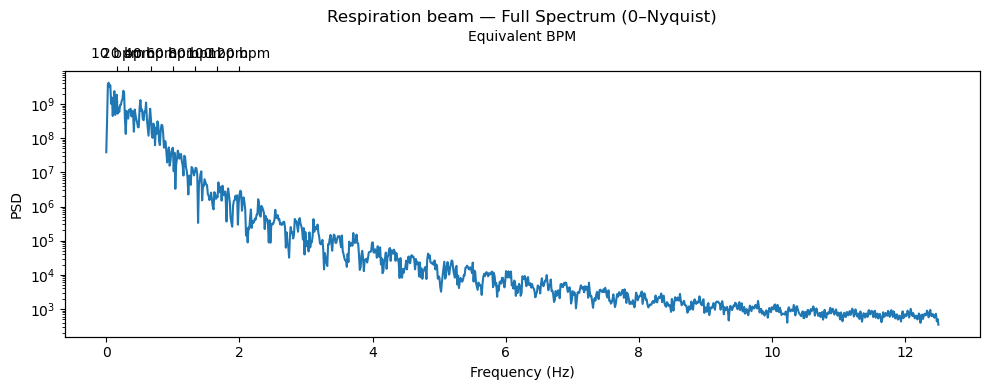

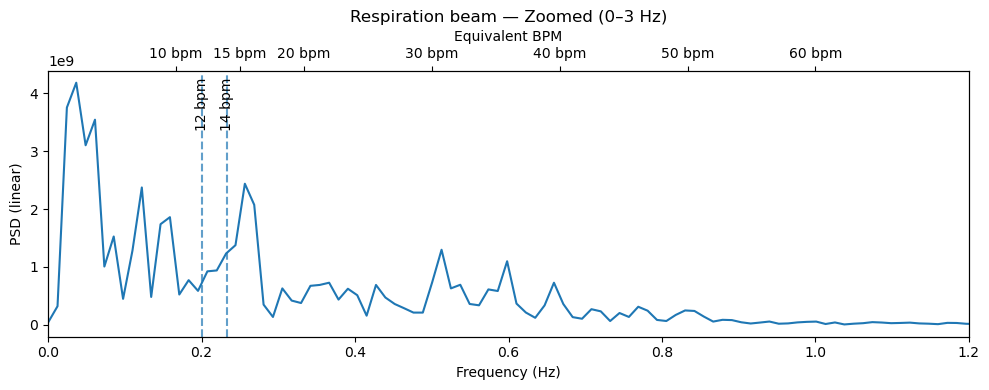

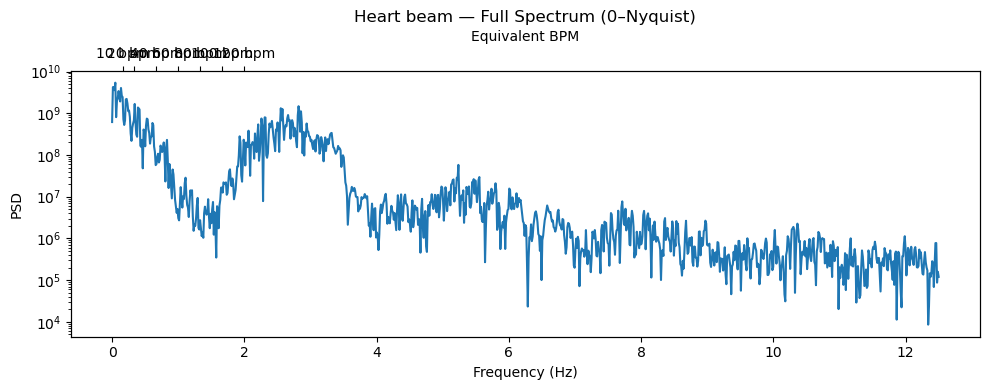

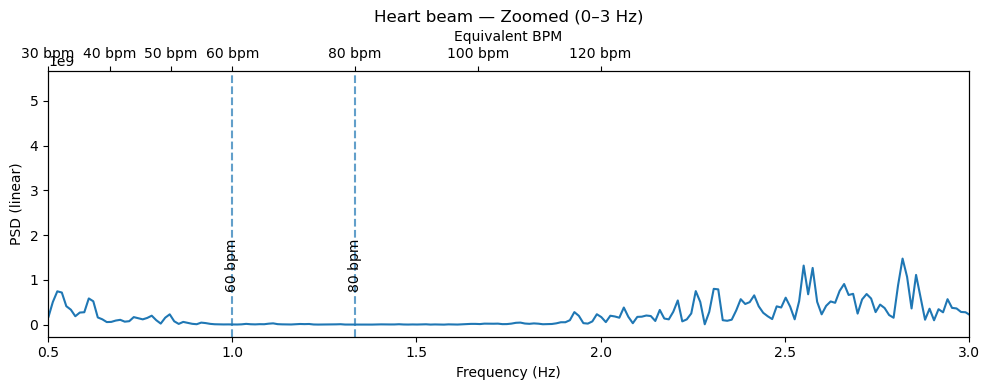

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, detrend

# ----------------------- I/O -----------------------
def load_complex_csv(path):
    """
    Load CSV saved with columns: real, imag (with header).
    Returns complex numpy array shape (N,).
    """
    data = np.loadtxt(path, delimiter=",", skiprows=1)
    return data[:, 0] + 1j * data[:, 1]

# ----------------------- DSP helpers -----------------------
def mag_series(xc):
    """Magnitude of complex series with mean removal (helps PSD near DC)."""
    return np.abs(detrend(xc, type="constant"))

def welch_psd(x, fs, nperseg=None):
    if nperseg is None:
        nperseg = min(len(x), 2048)
    f, Pxx = welch(x, fs=fs, nperseg=nperseg)
    return f, Pxx

def band_peak(x, fs, fmin, fmax):
    """Return (f_peak, P_peak) within [fmin, fmax]. np.nan if empty."""
    f, P = welch_psd(x, fs)
    m = (f >= fmin) & (f <= fmax)
    if not np.any(m):
        return np.nan, np.nan
    k = np.argmax(P[m])
    fpk = f[m][k]
    return fpk, P[m][k]

# ----------------------- Plotting -----------------------
def plot_full_spectrum(x, fs, title):
    f, Pxx = welch_psd(x, fs)
    plt.figure(figsize=(10, 4))
    plt.semilogy(f, Pxx)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.title(title + " — Full Spectrum (0–Nyquist)")
    # add BPM top axis
    ax = plt.gca()
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    bpm_ticks = [10, 20, 40, 60, 80, 100, 120]
    ax2.set_xticks(np.array(bpm_ticks) / 60.0)
    ax2.set_xticklabels([f"{b} bpm" for b in bpm_ticks])
    ax2.set_xlabel("Equivalent BPM")
    plt.tight_layout()

def plot_zoomed_with_markers(x, fs, title, rr_bpm=None, hr_bpm=None,
                             xlim_hz=(0, 3.0)):
    f, Pxx = welch_psd(x, fs)
    plt.figure(figsize=(10, 4))
    plt.plot(f, Pxx, linewidth=1.5)
    plt.xlim(xlim_hz)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (linear)")
    plt.title(title + " — Zoomed (0–3 Hz)")

    ymax = np.max(Pxx[(f >= xlim_hz[0]) & (f <= xlim_hz[1])]) if np.any((f >= xlim_hz[0]) & (f <= xlim_hz[1])) else np.max(Pxx)
    # mark RR candidates
    if rr_bpm:
        for bpm in rr_bpm:
            hz = bpm / 60.0
            if xlim_hz[0] <= hz <= xlim_hz[1]:
                plt.axvline(hz, linestyle="--", alpha=0.7)
                plt.text(hz, 0.8 * ymax, f"{bpm} bpm", rotation=90,
                         va="bottom", ha="center")
    # mark HR candidates
    if hr_bpm:
        for bpm in hr_bpm:
            hz = bpm / 60.0
            if xlim_hz[0] <= hz <= xlim_hz[1]:
                plt.axvline(hz, linestyle="--", alpha=0.7)
                plt.text(hz, 0.5 * ymax, f"{bpm} bpm", rotation=90,
                         va="bottom", ha="center")

    # BPM top axis
    ax = plt.gca()
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    # choose nice bpm ticks within the zoom
    hz_min, hz_max = ax.get_xlim()
    bpm_min, bpm_max = 60 * hz_min, 60 * hz_max
    bpm_ticks = [b for b in [10, 15, 20, 30, 40, 50, 60, 80, 100, 120] if bpm_min <= b <= bpm_max]
    if bpm_ticks:
        ax2.set_xticks(np.array(bpm_ticks) / 60.0)
        ax2.set_xticklabels([f"{b} bpm" for b in bpm_ticks])
    ax2.set_xlabel("Equivalent BPM")
    plt.tight_layout()

# ----------------------- Main -----------------------
if __name__ == "__main__":
    # --- set your frame rate here ---
    fs_time = 25.0  # Hz

    # Expected peaks to annotate
    RR_CANDIDATES = [14,12]       # bpm
    HR_CANDIDATES = [80, 60]    # bpm

    # Load beams (real,imag CSV with header)
    resp_beam_c = load_complex_csv("resp_beam_complex.csv")
    heart_beam_c = load_complex_csv("heart_beam_complex.csv")

    # Magnitude series for PSDs
    resp_mag = mag_series(resp_beam_c)
    heart_mag = mag_series(heart_beam_c)

    # ---- Respiration beam ----
    plot_full_spectrum(resp_mag, fs_time, "Respiration beam")
    plot_zoomed_with_markers(
        resp_mag, fs_time, "Respiration beam",
        rr_bpm=RR_CANDIDATES, hr_bpm=None, xlim_hz=(0.0, 1.2)
    )
    # compute and print measured RR peak in a reasonable band
    rr_pk_hz, _ = band_peak(resp_mag, fs_time, 0.1, 0.6)
    print(f"Respiration peak: {rr_pk_hz:.3f} Hz ({rr_pk_hz*60:.1f} bpm)")

    # ---- Heart beam ----
    plot_full_spectrum(heart_mag, fs_time, "Heart beam")
    plot_zoomed_with_markers(
        heart_mag, fs_time, "Heart beam",
        rr_bpm=None, hr_bpm=HR_CANDIDATES, xlim_hz=(0.5, 3.0)
    )
    # compute and print measured HR peak in a reasonable band
    hr_pk_hz, _ = band_peak(heart_mag, fs_time, 0.8, 2.5)
    print(f"Heart peak: {hr_pk_hz:.3f} Hz ({hr_pk_hz*60:.1f} bpm)")

    plt.show()


/home/jupyter-karla/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:598: UserWarning: n_components is too large: it will be set to 3
  warnings.warn(


AttributeError: module 'ewtpy' has no attribute 'Boundaries_Detect'

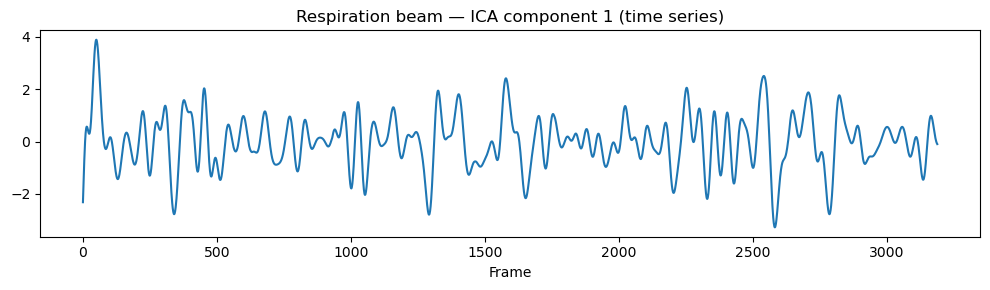

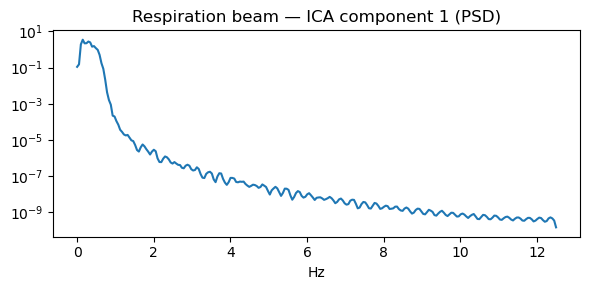

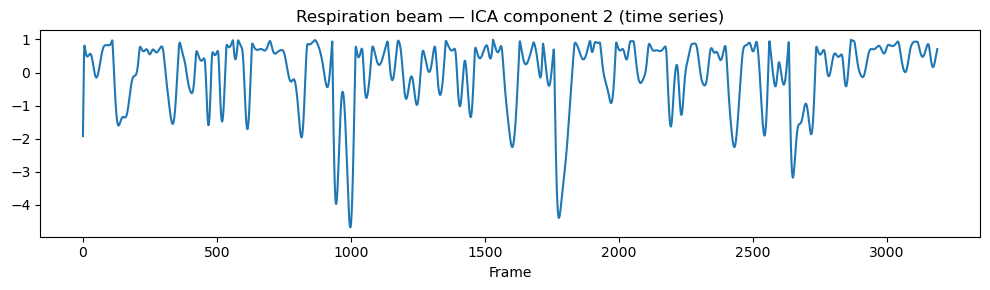

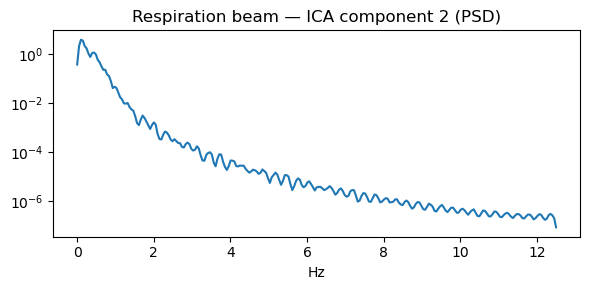

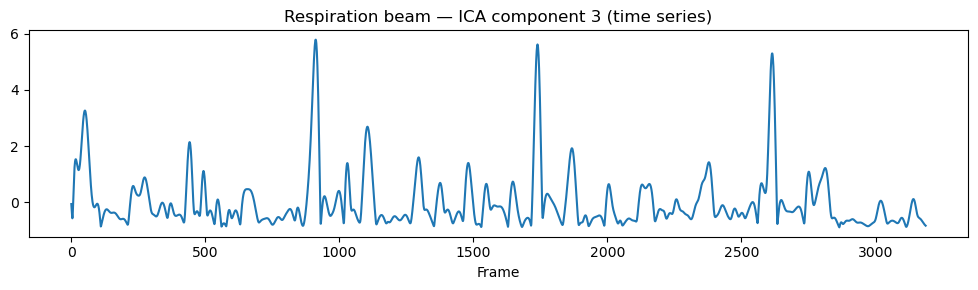

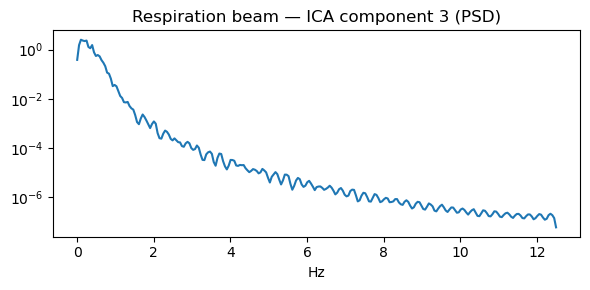

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, welch
from sklearn.decomposition import FastICA

# You need ewtpy: pip install ewtpy
import ewtpy  

# ----------------- Load beams -----------------
def load_complex_csv(path):
    data = np.loadtxt(path, delimiter=",", skiprows=1)
    return data[:, 0] + 1j * data[:, 1]

resp_beam_c = load_complex_csv("resp_beam_complex.csv")
heart_beam_c = load_complex_csv("heart_beam_complex.csv")

fs_time = 25.0  # Hz (frame rate, set correctly!)

# ----------------- Build ICA input -----------------
def build_matrix_for_ica(xc):
    """
    xc: complex series
    returns X: (frames, channels) for ICA
    channels = [real, imag, magnitude]
    """
    real = detrend(xc.real, type="constant")
    imag = detrend(xc.imag, type="constant")
    mag  = detrend(np.abs(xc), type="constant")
    X = np.stack([real, imag, mag], axis=1)
    return X

def run_ica(X, n_components=5):
    ica = FastICA(n_components=n_components, random_state=0, max_iter=1000)
    S = ica.fit_transform(X)  # (frames, comps)
    return S

# ----------------- EWT decomposition -----------------
def run_ewt(signal, fs, N=0):
    """
    signal: 1D array (real)
    fs: sampling rate
    N: if >0 force number of bands, else automatic
    """
    if N > 0:
        boundaries = ewtpy.Boundaries_Adapt(signal, N)
    else:
        boundaries = ewtpy.Boundaries_Detect(signal, N=0)
    ewt, mfb, boundaries = ewtpy.EWT1D(signal, boundaries)
    return ewt, boundaries

# ----------------- Plot helpers -----------------
def plot_components(S, fs, title):
    """Plot ICA components and their PSDs."""
    n = S.shape[1]
    for k in range(n):
        plt.figure(figsize=(10,3))
        plt.plot(S[:,k])
        plt.title(f"{title} — ICA component {k+1} (time series)")
        plt.xlabel("Frame"); plt.tight_layout()

        f, P = welch(S[:,k], fs=fs, nperseg=512)
        plt.figure(figsize=(6,3))
        plt.semilogy(f, P)
        plt.title(f"{title} — ICA component {k+1} (PSD)")
        plt.xlabel("Hz"); plt.tight_layout()

def plot_ewt_modes(modes, fs, title):
    """Plot EWT modes and their PSDs."""
    for m, mode in enumerate(modes, start=1):
        plt.figure(figsize=(10,5))
        plt.plot(mode)
        plt.title(f"{title} — EWT mode {m} (time series)")
        plt.xlabel("Frame"); plt.tight_layout()

        f, P = welch(mode, fs=fs, nperseg=512)
        plt.figure(figsize=(6,3))
        plt.semilogy(f, P)
        plt.title(f"{title} — EWT mode {m} (PSD)")
        plt.xlabel("Hz"); plt.tight_layout()

# ----------------- Main -----------------
if __name__ == "__main__":
    # --- Respiration beam ---
    Xr = build_matrix_for_ica(resp_beam_c)
    Sr = run_ica(Xr, n_components=5)
    plot_components(Sr, fs_time, "Respiration beam")

    # Run EWT on each ICA component
    for k in range(Sr.shape[1]):
        modes, bounds = run_ewt(Sr[:,k], fs_time)
        plot_ewt_modes(modes, fs_time, f"Respiration ICA comp {k+1}")

    # --- Heart beam ---
    Xh = build_matrix_for_ica(heart_beam_c)
    Sh = run_ica(Xh, n_components=5)
    plot_components(Sh, fs_time, "Heart beam")

    for k in range(Sh.shape[1]):
        modes, bounds = run_ewt(Sh[:,k], fs_time)
        plot_ewt_modes(modes, fs_time, f"Heart ICA comp {k+1}")

    plt.show()
